# Vertical Interpolation

The `aus400.vertical` module has tools for interpolating Aus400 output to different vertical levels.

The Unified Model runs with hybrid height levels - levels follow the orography at low levels, and are at fixed heights at high levels. The true altitude of each grid cell is available in `stream='fx', variable='height_rho'`.

`aus400.vertical.to_plev(da, levels)` and `aus400.vertical.to_height(da, levels)` will vertically interpolate 'da' to a set of fixed pressure or height levels respectively.

In [1]:
import sys
sys.path.append('..')
import aus400
import numpy

In [2]:
# Start a Dask distributed client if running on Gadi so memory limits are respected
import climtas.nci
climtas.nci.GadiClient()

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: /proxy/8787/status,
Status: running,Using processes: True
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 1,Total memory: 4.00 GiB
Comm: tcp://127.0.0.1:45035,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 1
Started: Just now,Total memory: 4.00 GiB
Comm: tcp://127.0.0.1:38535,Total threads: 1
Dashboard: /proxy/34067/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:36123,


## Levels of the source data

Data as published is on model levels. There are two level types - 'rho' levels and 'theta' levels, each offset half a grid spacing from the other.

The `level_height` coordinate in the data is what the height of that level would be if the orographic height was at zero. `sigma` is how much the orographic height influences the height at that level.

The true height of a grid cell is `level_height + sigma * orography`, for convenience this is available pre-calculated under the `fx` stream.

In [3]:
ta = aus400.load_var(resolution='d0198', stream='mdl', variable='air_temp', ensemble=0, time='20170327T0000')
ta

<xarray.DataArray 'air_temp' (ensemble: 1, time: 1, model_level_number: 90, latitude: 2120, longitude: 2600)>
dask.array<broadcast_to, shape=(1, 1, 90, 2120, 2600), dtype=float32, chunksize=(1, 1, 1, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) datetime64[ns] 2017-03-27T01:00:00
  * model_level_number       (model_level_number) int32 1 2 3 4 ... 87 88 89 90
  * latitude                 (latitude) float32 -48.79 -48.77 ... -6.852 -6.832
  * longitude                (longitude) float32 107.5 107.5 ... 159.0 159.0
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
    level_height             (model_level_number) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sigma                    (model_level_number) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * ensemble                 (ensemble) int64 0
Attributes:
    standard_name:           air_temperature
    units:                   K
    source:                  Data from Met Office Unified Model
    um_version:              11.4
    STASH:                   [ 1 16  4]
    um_stash_source:         m01s16i004
    long_name:               TEMPERATURE ON THETA LEVELS
    stash_code:              16004
    wgdos_packing_accuracy:  2^-3
    resolution:              d0198
    stream:                  mdl

## Interpolating

To convert to pressure or height levels use `to_plev(da, levels)` or `to_height(da, levels)` respectively. These are using [xgcm](https://xgcm.readthedocs.io/en/latest/transform.html) to do the interpolation.

Arbitrary interpolation is supported using `vertical_interp(da, source, levels)`. Here `source` is the current Z values at each grid cell - `to_plev()` and `to_height()` are special cases of this function

In [4]:
# 1 kPa pressure level
ta_plev = aus400.vertical.to_plev(ta, numpy.array([1000]))
ta_plev

<xarray.DataArray 'air_temp' (ensemble: 1, time: 1, latitude: 2120, longitude: 2600, pressure: 1)>
dask.array<transpose, shape=(1, 1, 2120, 2600, 1), dtype=float32, chunksize=(1, 1, 500, 500, 1), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) datetime64[ns] 2017-03-27T01:00:00
  * latitude                 (latitude) float32 -48.79 -48.77 ... -6.852 -6.832
  * longitude                (longitude) float32 107.5 107.5 ... 159.0 159.0
    forecast_period          timedelta64[ns] 19:00:00
    forecast_reference_time  datetime64[ns] 2017-03-26T06:00:00
  * ensemble                 (ensemble) int64 0
  * pressure                 (pressure) int64 1000

CPU times: user 44 s, sys: 1.55 s, total: 45.5 s
Wall time: 3min 42s


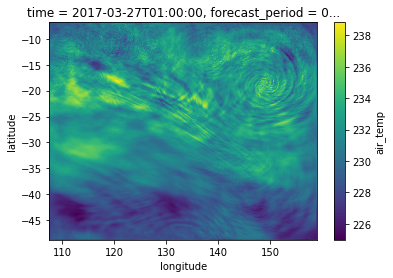

In [5]:
%%time
# The squeeze() here drops the length-1 dimensions as they interfere with plotting
ta_plev.squeeze().plot.imshow();

In [6]:
# 1 km height above sea level
ta_height = aus400.vertical.to_height(ta, numpy.array([1000]))
ta_height

<xarray.DataArray 'air_temp' (ensemble: 1, time: 1, latitude: 2120, longitude: 2600, height_rho: 1)>
dask.array<transpose, shape=(1, 1, 2120, 2600, 1), dtype=float32, chunksize=(1, 1, 500, 500, 1), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 2017-03-27T01:00:00
  * latitude    (latitude) float32 -48.79 -48.77 -48.75 ... -6.871 -6.852 -6.832
  * longitude   (longitude) float32 107.5 107.5 107.6 ... 158.9 159.0 159.0
  * ensemble    (ensemble) int64 0
  * height_rho  (height_rho) int64 1000

CPU times: user 42.4 s, sys: 1.49 s, total: 43.9 s
Wall time: 3min 46s


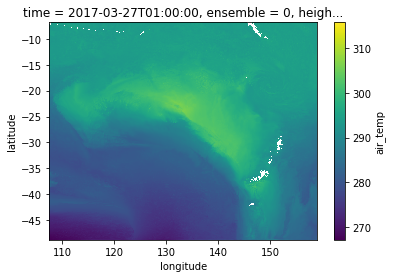

In [7]:
%%time
ta_height.squeeze().plot.imshow();